# CLL788 Term Paper Assignment

## Topic: LIPNET: END-TO-END SENTENCE-LEVEL LIPREADING
## By: Yannis M. Assael, Brendan Shillingford, Shimon Whiteson and Nando de Freitas
Paper Link: https://arxiv.org/abs/1611.01599

## By: Meet Jain
## Entry Number: 2023PHS7210

In [1]:
# Uncomment and run the cell to install the requirements
# !pip install -r requirements.txt

In [2]:
# Run the below command to verify the proper package installations(Ignore the warnings)
!python3 test_environment.py

2025-04-16 04:50:37.405390: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744779037.519641    2661 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744779037.553157    2661 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744779037.810391    2661 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744779037.810747    2661 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744779037.810753    2661 computation_placer.cc:177] computation placer alr

# 1. Libraries Import

In [3]:
import tensorflow as tf
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import GlorotUniform, Orthogonal, Constant, HeNormal
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import imageio
import gdown
import dlib
from tqdm import tqdm
import warnings
import cv2

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (9, 5)

2025-04-16 04:50:44.081736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744779044.108108    2552 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744779044.115773    2552 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744779044.133193    2552 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744779044.133215    2552 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744779044.133218    2552 computation_placer.cc:177] computation placer alr

In [4]:
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print(f"Configured memory growth for GPU: {physical_devices[0]}")
    else:
        print("No GPU found, running on CPU.")
except Exception as e:
    print(f"Could not set memory growth: {e}")

SEED = 42

Configured memory growth for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
FRAME_COUNT = 75 
FRAME_HEIGHT = 50 
FRAME_WIDTH = 100 
FRAME_CHANNELS = 3

# 2. Dataset Download
Uncomment and run the below cell to download the dataset

In [6]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

# 3. Mouth Extraction and Saving

Uncomment below cell and run to download the pretrained face detector model as used in the paper.

In [7]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !bunzip2 shape_predictor_68_face_landmarks.dat.bz2

In [8]:
# Initializing the pre-trained face detector model from DLib package to extract the mouth regions from each of the frames.
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [9]:
def extract_mouth_region(frame:np.array):
    # Convert to grayscale for detection only
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) == 0:
        return None
    # Using the first detected face
    face = faces[0]
    landmarks = predictor(gray, face)
    # Landmarks corresponding to the mouth: 48-68
    points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(48, 68)]
    points = np.array(points)
    
    # Bounding box around the mouth landmarks
    x, y, w, h = cv2.boundingRect(points)
    margin = 30
    x = max(x - margin, 0)
    y = max(y - margin, 0)
    cropped = frame[y+15:y+h+margin+15, x+15:x+w+margin+15]
    # Resize to 100x50, keeping all 3 channels
    cropped = cv2.resize(cropped, (FRAME_WIDTH, FRAME_HEIGHT))
    return cropped

def process_video(video_path:str, output_dir:str) -> None:
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for _ in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        mouth_frame = extract_mouth_region(frame)
        if mouth_frame is not None:
            frames.append(mouth_frame)
        else:
            # If detection fails
            frames.append(np.zeros((50, 100, 3), dtype=np.uint8))
    cap.release()

    video_id = os.path.splitext(os.path.basename(video_path))[0]
    np.save(os.path.join(output_dir, f"{video_id}_mouth.npy"), np.array(frames))
    return None

# input_videos_dir = "./data/s1"
# output_preprocessed_dir = "./processed_mouth_data/s1"
# # output_preprocessed_dir = "./1_processed_mouth_data"
# os.makedirs(output_preprocessed_dir, exist_ok=True)
# video_files = [os.path.join(input_videos_dir, f) for f in os.listdir(input_videos_dir) if f.endswith(".mpg")]

# for video_file in tqdm(video_files, desc="Overall video processing", unit="video"):
#     process_video(video_file, output_preprocessed_dir)

In [12]:
def create_gif_from_npy(npy_path:str, gif_path:str, duration:float=0.04) -> None:
    frames = np.load(npy_path)  # Expected shape: (num_frames, height, width, channels)
    # The duration parameter sets the time per frame, 0.04s for 25fps.
    imageio.mimsave(gif_path, frames, duration=duration)
    return None

# npy_path = "processed_mouth_data/s1/swwc7a_mouth.npy"
gif_path = "./swwc7a_mouth.gif"
# create_gif_from_npy(npy_path, gif_path)

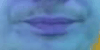

In [13]:
# See the extracted mouth region as a GIF file.
from IPython.display import Image, display
display(Image(filename=gif_path))

# 4. Basic Configuration

In [14]:
BASE_PROCESSED_PATH = './processed_mouth_data/' 
BASE_ALIGN_PATH = './data/alignments/'      

ALL_SPEAKER_IDS = [f's{i}' for i in range(1, 2) if i != 21]

TEST_SPEAKERS_UNSEEN = ['s1', 's2', 's20', 's22'] 
NUM_TEST_SENTENCES_OVERLAPPED = 200 
SPLIT_MODE = 'overlapped' 

In [15]:
# Normalization constants from paper (Appendix A.2)
NORM_MEAN = tf.constant([0.7136, 0.4906, 0.3283], dtype=tf.float32)
NORM_STD = tf.constant([0.1138, 0.1078, 0.0917], dtype=tf.float32)

I0000 00:00:1744779077.555967    2552 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13775 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# 5. Constructing Vocabulary and Character Mapping

In [16]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="", name='char_to_num')
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True, name='num_to_char'
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

LABEL_PADDING_VALUE = tf.cast(0, dtype=tf.int32)

CTC_BLANK_INDEX = char_to_num.vocabulary_size() 
print(f"CTC Blank Index: {CTC_BLANK_INDEX}")

The vocabulary is: ['', np.str_('a'), np.str_('b'), np.str_('c'), np.str_('d'), np.str_('e'), np.str_('f'), np.str_('g'), np.str_('h'), np.str_('i'), np.str_('j'), np.str_('k'), np.str_('l'), np.str_('m'), np.str_('n'), np.str_('o'), np.str_('p'), np.str_('q'), np.str_('r'), np.str_('s'), np.str_('t'), np.str_('u'), np.str_('v'), np.str_('w'), np.str_('x'), np.str_('y'), np.str_('z'), np.str_(' ')] (size =28)
CTC Blank Index: 28


# 6. Video Loading and Normalization

In [17]:
def load_and_normalize_video(npy_path):
    """Loads, normalizes, and ensures correct shape for a video npy file."""
    try:
        frames = np.load(npy_path)
        frames = frames.astype(np.float32) / 255.0
        frames = frames[..., ::-1] # BGR to RGB

        if frames.ndim != 4 or frames.shape[-1] != 3:
             raise ValueError(f"Unexpected frame shape: {frames.shape}")

        # Ensure correct number of frames (T=75)
        if frames.shape[0] != FRAME_COUNT:
            if frames.shape[0] > FRAME_COUNT:
                frames = frames[:FRAME_COUNT, ...]
            else:
                pad_width = ((0, FRAME_COUNT - frames.shape[0]), (0, 0), (0, 0), (0, 0))
                frames = np.pad(frames, pad_width, mode='constant', constant_values=0)

        means = np.array([0.7136, 0.4906, 0.3283], dtype=np.float32)
        stds = np.array([0.1138, 0.1078, 0.0917], dtype=np.float32)
        frames = (frames - means) / stds
        video_tensor = tf.convert_to_tensor(frames, dtype=tf.float32)
        video_tensor.set_shape([FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS])
        return video_tensor
    except Exception as e:
        print(f"Error loading or processing video {npy_path}: {e}")
        return None

example_npy_path = "./processed_mouth_data/s1/bbwt1a_mouth.npy"
example_video_tensor = load_and_normalize_video(example_npy_path)
print(f"Loaded Video Shape: {example_video_tensor.shape}")

Loaded Video Shape: (75, 50, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.236845..2.1931493].


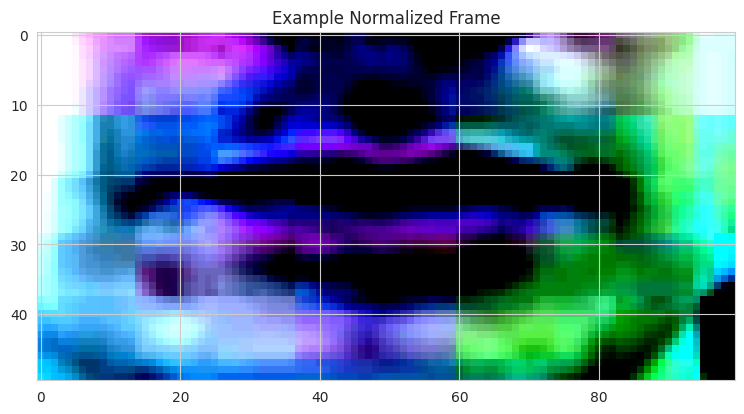

In [18]:
plt.imshow(example_video_tensor.numpy()[0])
plt.title("Example Normalized Frame")
plt.show()

# 7. Alignments Loading

In [19]:
def get_transcript_for_file(npy_path_str):
    """Looks up the transcript string for a given npy file path."""
    try:
        parts = npy_path_str.split(os.path.sep)
        speaker_id = parts[-2]
        base_name = os.path.splitext(parts[-1])[0]
        if base_name.endswith('_mouth'):
            base_name = base_name[:-6]
        align_file = os.path.join(BASE_ALIGN_PATH, speaker_id, f'{base_name}.align')

        full_sentence = []
        with open(align_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 3 and parts[2] != 'sil':
                    full_sentence.append(parts[2])

        transcript = " ".join(full_sentence).lower()
        if not transcript:
             print(f"Warning: Empty transcript found for {align_file}")
             return "" 
        return transcript
    except Exception as e:
        print(f"Error getting transcript for {npy_path_str}: {e}")
        return None 

example_npy_path = "./processed_mouth_data/s1/bbwt1a_mouth.npy"
example_alignment = get_transcript_for_file(example_npy_path)
print(f"Alignment for video: {example_npy_path} is"
     f"\n{example_alignment}")

Alignment for video: ./processed_mouth_data/s1/bbwt1a_mouth.npy is
bin blue with t one again


In [20]:
def load_alignments(align_file:str) -> List[str]:
    """Reads an alignment file and returns list of characters for CTC."""
    alignments_chars = []
    try:
        with open(align_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) != 3:
                    continue
                _, _, token = parts
                if token != 'sil':
                    token_characters = list(token.lower()+' ')
                    alignments_chars.extend(token_characters)

        return alignments_chars[:-1] if alignments_chars else []
    except Exception as e:
        print(f"Error loading alignments {align_file}: {e}")
        return None 

example_align_path = "./data/alignments/s1/lbwr2n.align"
example_alignment = load_alignments(example_align_path)
print(f"Alignment for file: {example_align_path} is"
     f"\n{example_alignment}")

Alignment for file: ./data/alignments/s1/lbwr2n.align is
['l', 'a', 'y', ' ', 'b', 'l', 'u', 'e', ' ', 'w', 'i', 't', 'h', ' ', 'r', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']


# 8. Data Pipeline

## 8.1 File Listing and Splitting

In [21]:
all_npy_files = []
for speaker_id in ALL_SPEAKER_IDS:
    speaker_path = os.path.join(BASE_PROCESSED_PATH, speaker_id, '*.npy')
    files = glob.glob(speaker_path)
    if not files:
         print(f"Warning: No .npy files found for speaker {speaker_id} in {os.path.join(BASE_PROCESSED_PATH, speaker_id)}")
    all_npy_files.extend(files)

if not all_npy_files:
    raise FileNotFoundError(f"No .npy files found in {BASE_PROCESSED_PATH} for speakers {ALL_SPEAKER_IDS}")

np.random.seed(SEED) # for reproducible splits
np.random.shuffle(all_npy_files)

train_files, test_files = [], []

if SPLIT_MODE == 'unseen':
    print(f"Using unseen speakers split. Test speakers: {TEST_SPEAKERS_UNSEEN}")
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id in TEST_SPEAKERS_UNSEEN:
            test_files.append(f)
        else:
            train_files.append(f)
elif SPLIT_MODE == 'overlapped':
    print(f"Using overlapped speakers split. {NUM_TEST_SENTENCES_OVERLAPPED} test sentences per speaker.")
    files_by_speaker = {}
    for f in all_npy_files:
        speaker_id = os.path.basename(os.path.dirname(f))
        if speaker_id not in files_by_speaker:
            files_by_speaker[speaker_id] = []
        files_by_speaker[speaker_id].append(f)

    for speaker_id, files in files_by_speaker.items():
        np.random.shuffle(files)
        test_count = min(NUM_TEST_SENTENCES_OVERLAPPED, len(files))
        test_files.extend(files[:test_count])
        train_files.extend(files[test_count:])
else:
    raise ValueError("Invalid SPLIT_MODE. Choose 'unseen' or 'overlapped'.")

print(f"Total files found: {len(all_npy_files)}")
print(f"Training files: {len(train_files)}")
print(f"Test files: {len(test_files)}")

if not train_files or not test_files:
     raise ValueError("Training or test set is empty. Check file paths and splitting logic.")

train_data_files = tf.data.Dataset.from_tensor_slices(train_files)
test_data_files = tf.data.Dataset.from_tensor_slices(test_files)

Using overlapped speakers split. 200 test sentences per speaker.
Total files found: 1000
Training files: 800
Test files: 200


## 8.2 Mapping Function

In [22]:
def load_data_tf(path_tensor):
    path = bytes.decode(path_tensor.numpy())
    file_name = os.path.splitext(os.path.basename(path))[0]
    speaker_id = os.path.basename(os.path.dirname(path))

    base_name = file_name
    if base_name.endswith('_mouth'):
         base_name = base_name[:-6]
    alignment_path = os.path.join(BASE_ALIGN_PATH, speaker_id, f'{base_name}.align')

    frames_tensor = load_and_normalize_video(path)
    alignments_list = load_alignments(alignment_path) 

    if frames_tensor is None or alignments_list is None:
        # Return tensors with zero length / empty strings to be filtered out
        frames_tensor = tf.zeros([FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS], dtype=tf.float32)
        # Return an empty tensor of strings for alignments
        alignments_str_tensor = tf.constant([], dtype=tf.string)
        video_length = tf.constant(0, dtype=tf.int32)
        label_length = tf.constant(0, dtype=tf.int32) # Length is 0 for empty alignments
        return frames_tensor, alignments_str_tensor, video_length, label_length

    # Convert list of characters to a Tensor of strings
    alignments_str_tensor = tf.constant(alignments_list, dtype=tf.string)

    video_length = tf.shape(frames_tensor)[0]
    label_length = tf.shape(alignments_str_tensor)[0] # Get length of the string tensor

    # Return the STRING tensor for alignments now
    return frames_tensor, alignments_str_tensor, tf.cast(video_length, dtype=tf.int32), tf.cast(label_length, dtype=tf.int32)


# Wrapper for tf.py_function
def mappable_function_tf(path):
    # Output types from the Python function load_data_tf
    frames, alignments_str, vid_len, align_len = tf.py_function(
        load_data_tf,
        [path],
        # Expect STRING for alignments now
        [tf.float32, tf.string, tf.int32, tf.int32]
    )

    # --- Set shape for the string tensor immediately ---
    # This gives the StringLookup layer enough info (rank=1)
    alignments_str.set_shape([None])
    # ----------------------------------------------------

    # --- Apply char_to_num mapping HERE (in the TF graph) ---
    alignments_int = char_to_num(alignments_str)
    # Cast explicitly to int32 for consistency and CTC loss
    alignments_int = tf.cast(alignments_int, dtype=tf.int32)
    # ---------------------------------------------------------

    # Set shapes for the final outputs for graph mode compatibility
    frames.set_shape([FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS])
    # The shape of alignments_int is already known from char_to_num,
    # but setting it again doesn't hurt.
    alignments_int.set_shape([None])
    vid_len.set_shape([])
    align_len.set_shape([])

    # Return INTEGER alignments for the rest of the pipeline
    return frames, alignments_int, vid_len, align_len

## 8.3 Frame Augmentation Function

In [23]:
def apply_augmentations(video_frames, label_indices, video_length, label_length):
    if tf.random.uniform(()) > 0.5:
        video_frames = tf.image.flip_left_right(video_frames)
    return video_frames, label_indices, video_length, label_length

## 8.4 Filter Function

In [24]:
def filter_bad_samples(video_frames, label_indices, video_length, label_length):
    # Filter out samples where loading failed (indicated by zero length)
    return tf.logical_and(video_length > 0, label_length > 0)

## 8.5 Final Data Pipeline

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = (
    train_data_files
    .shuffle(len(train_files), reshuffle_each_iteration=True)
    .map(mappable_function_tf, num_parallel_calls=AUTOTUNE) # Outputs float32, int32, int32, int32
    .filter(filter_bad_samples)
    .map(apply_augmentations, num_parallel_calls=AUTOTUNE)
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=(
            [FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS], # Video shape
            [None],  # Label shape (variable length)
            [],      # Video length shape (scalar)
            []       # Label length shape (scalar)
        ),
        padding_values=(
            tf.constant(0.0, dtype=tf.float32),      # Padding for frames
            LABEL_PADDING_VALUE,                     # Padding for labels (int32)
            tf.constant(0, dtype=tf.int32),          # Padding for video length
            tf.constant(0, dtype=tf.int32)           # Padding for label length
            )
    )
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data_files
    .map(mappable_function_tf, num_parallel_calls=AUTOTUNE) # Outputs float32, int32, int32, int32
    .filter(filter_bad_samples)
    # No augmentations on test set
    .padded_batch(
        BATCH_SIZE,
        padded_shapes=(
             [FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS],
            [None],
            [],
            []
        ),
        padding_values=(
            tf.constant(0.0, dtype=tf.float32),
            LABEL_PADDING_VALUE, # int32
            tf.constant(0, dtype=tf.int32),
            tf.constant(0, dtype=tf.int32)
            )
    )
    .repeat() # Make repeatable for validation across epochs
    .prefetch(AUTOTUNE)
)

print("Data pipelines created successfully:)")

Data pipelines created successfully:)


# 9. LipNet Model Definition

In [26]:
class LipNet(Model):
    def __init__(self, num_classes, dropout_p=0.5, name="LipNet", **kwargs):
        super().__init__(name=name, **kwargs)
        # num_classes should include the blank label (e.g., 28 + 1 = 29)
        self.num_classes = num_classes
        self.dropout_p = dropout_p

        conv_init = HeNormal(seed=42)
        gru_kernel_init = GlorotUniform(seed=42)
        gru_recurrent_init = Orthogonal(seed=42)
        dense_init = HeNormal(seed=42)
        zeros_init = Constant(0.)

        self.conv1 = layers.Conv3D(32, (3, 5, 5), strides=(1, 2, 2), padding='same',
                                   kernel_initializer=conv_init, bias_initializer=zeros_init, name='conv1')
        self.bn1 = layers.BatchNormalization(name='bn1')
        self.act1 = layers.ReLU(name='relu1')
        self.pool1 = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='pool1')
        self.drop1 = layers.SpatialDropout3D(dropout_p, name='spatial_drop1')

        self.conv2 = layers.Conv3D(64, (3, 5, 5), strides=(1, 1, 1), padding='same',
                                   kernel_initializer=conv_init, bias_initializer=zeros_init, name='conv2')
        self.bn2 = layers.BatchNormalization(name='bn2')
        self.act2 = layers.ReLU(name='relu2')
        self.pool2 = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='pool2')
        self.drop2 = layers.SpatialDropout3D(dropout_p, name='spatial_drop2')

        self.conv3 = layers.Conv3D(96, (3, 3, 3), strides=(1, 1, 1), padding='same',
                                   kernel_initializer=conv_init, bias_initializer=zeros_init, name='conv3')
        self.bn3 = layers.BatchNormalization(name='bn3')
        self.act3 = layers.ReLU(name='relu3')
        self.pool3 = layers.MaxPool3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='pool3')
        self.drop3 = layers.SpatialDropout3D(dropout_p, name='spatial_drop3')

        self.timedist_flatten = layers.TimeDistributed(layers.Flatten(), name='timedist_flatten')

        self.gru1 = layers.Bidirectional(layers.GRU(256, return_sequences=True,
                                                     kernel_initializer=gru_kernel_init,
                                                     recurrent_initializer=gru_recurrent_init,
                                                     bias_initializer=zeros_init), merge_mode='concat', name='bi_gru1')
        self.drop_gru1 = layers.Dropout(dropout_p, name='drop_gru1')

        self.gru2 = layers.Bidirectional(layers.GRU(256, return_sequences=True,
                                                     kernel_initializer=gru_kernel_init,
                                                     recurrent_initializer=gru_recurrent_init,
                                                     bias_initializer=zeros_init), merge_mode='concat', name='bi_gru2')
        self.drop_gru2 = layers.Dropout(dropout_p, name='drop_gru2')

        self.dense = layers.Dense(self.num_classes, kernel_initializer=dense_init,
                                  bias_initializer=zeros_init, name='dense_output', dtype=tf.float32)

    def call(self, inputs, training=None):
        x = self.conv1(inputs)
        x = self.bn1(x, training=training)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training)

        x = self.conv2(x)
        x = self.bn2(x, training=training)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.drop2(x, training=training)

        x = self.conv3(x)
        x = self.bn3(x, training=training)
        x = self.act3(x)
        x = self.pool3(x)
        x = self.drop3(x, training=training)

        x = self.timedist_flatten(x)

        x = self.gru1(x, training=training)
        x = self.drop_gru1(x, training=training)

        x = self.gru2(x, training=training)
        x = self.drop_gru2(x, training=training)

        logits = self.dense(x)
        return logits

    def build_graph(self, input_shape=(FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS)):
         # Input shape: (T, H, W, C)
        x = layers.Input(shape=input_shape)
        return Model(inputs=[x], outputs=self.call(x), name="LipNet_Functional")

# --- Instantiate and Build Model ---
lipnet_model = LipNet(num_classes=char_to_num.vocabulary_size() + 1) # Add 1 for CTC blank
lipnet_model.build_graph().summary()

Model: "LipNet_Functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 75, 50, 100, 3) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv3D)                  │ (None, 75, 25, 50, 32) │         7,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 75, 25, 50, 32) │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1 (ReLU)                    │ (None, 75, 25, 50, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling3D)            │ (None, 75, 12, 25, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop1                   │ (None, 75, 12, 25, 32) │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv3D)                  │ (None, 75, 12, 25, 64) │       153,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 75, 12, 25, 64) │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2 (ReLU)                    │ (None, 75, 12, 25, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling3D)            │ (None, 75, 6, 12, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop2                   │ (None, 75, 6, 12, 64)  │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv3D)                  │ (None, 75, 6, 12, 96)  │       165,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3 (BatchNormalization)        │ (None, 75, 6, 12, 96)  │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3 (ReLU)                    │ (None, 75, 6, 12, 96)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling3D)            │ (None, 75, 3, 6, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_drop3                   │ (None, 75, 3, 6, 96)   │             0 │
│ (SpatialDropout3D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ timedist_flatten                │ (None, 75, 1728)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_gru1 (Bidirectional)         │ (None, 75, 512)        │     3,050,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_gru1 (Dropout)             │ (None, 75, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bi_gru2 (Bidirectional)         │ (None, 75, 512)        │     1,182,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_gru2 (Dropout)             │ (None, 75, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_output (Dense)            │ (None, 75, 29)         │        14,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,575,741 (17.46 MB)

 Trainable params: 4,575,357 (17.45 MB)

 Non-trainable params: 384 (1.50 KB)

# 10. Loss Function

In [30]:
def dense_to_sparse(dense_tensor, sequence_lengths):
    """Converts dense padded tensor to SparseTensor required by ctc_loss."""
    # Ensure both tensors being compared are int32
    dense_tensor_int32 = tf.cast(dense_tensor, dtype=tf.int32)
    padding_value_int32 = tf.cast(LABEL_PADDING_VALUE, dtype=tf.int32) # Re-affirm type

    indices = tf.where(tf.not_equal(dense_tensor_int32, padding_value_int32))
    values = tf.gather_nd(dense_tensor_int32, indices) # Use the int32 tensor here too
    dense_shape = tf.cast(tf.shape(dense_tensor_int32), dtype=tf.int64)
    return tf.SparseTensor(indices, values, dense_shape)

def CTCLoss(y_true, y_pred, input_length, label_length):
    input_length = tf.cast(tf.squeeze(input_length), dtype=tf.int32)
    label_length = tf.cast(tf.squeeze(label_length), dtype=tf.int32)
    y_true = tf.cast(y_true, dtype=tf.int32)
    logits_time_major = tf.transpose(y_pred, perm=[1, 0, 2])
    sparse_labels = dense_to_sparse(y_true, label_length)

    loss = tf.nn.ctc_loss(
        labels=sparse_labels,
        logits=logits_time_major,
        label_length=label_length,
        logit_length=input_length,
        logits_time_major=True,
        blank_index=CTC_BLANK_INDEX
    )
    safe_loss = tf.where(tf.math.is_finite(loss), loss, tf.zeros_like(loss))
    return tf.reduce_mean(safe_loss)

# 11. Callbacks

In [31]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, example_dataset) -> None:
        # Take one batch and cache it
        self.example_data = next(iter(example_dataset.cache()))
        super().__init__()

    def on_epoch_end(self, epoch, logs=None, current_model=None) -> None:
        if current_model is None:
             print("\nWarning: current_model not passed to ProduceExample callback.")
             return

        data = self.example_data
        yhat = current_model.predict(data[0], verbose=0)

        # Input length for ctc_decode should be actual sequence lengths
        # In this model, input length is fixed at FRAME_COUNT (75)
        batch_actual_input_lengths = tf.cast(tf.fill([tf.shape(yhat)[0]], FRAME_COUNT), dtype='int32')

        # Use greedy=True for easier debugging
        # ctc_decode returns a list of tensors; take the first one ([0])
        # The tensor inside is often sparse; take the dense version ([0])
        decoded_dense = tf.keras.backend.ctc_decode(yhat, batch_actual_input_lengths, greedy=True)[0][0]

        print("\n\n--- Example Predictions (Epoch {}) ---".format(epoch+1))
        for i in range(min(len(yhat), 2)): # Show first 2 examples
            # 1. Original Label
            original_indices = data[1][i][:data[3][i]] # Slice using actual label length
            original_text = tf.strings.reduce_join(num_to_char(original_indices)).numpy().decode('utf-8')
            print(f'Original:     {original_text}')

            # 2. Raw Decoded Indices (Before Filtering)
            raw_decoded_indices = decoded_dense[i].numpy()
            print(f'Raw Decoded:  {raw_decoded_indices}') # See what ctc_decode outputs

            # 3. Filtered Indices
            # Remove padding (-1 typically returned by ctc_decode for shorter sequences)
            # Remove the CTC blank token (index 28 in our case)
            filtered_indices = [x for x in raw_decoded_indices if x != -1 and x != CTC_BLANK_INDEX]
            print(f'Filtered Idx: {filtered_indices}') # See what remains after filtering

            # 4. Final Prediction Text
            # Ensure num_to_char handles the filtered indices correctly
            # Need to cast filtered_indices back to tensor if not empty
            if filtered_indices:
                 prediction_text = tf.strings.reduce_join(num_to_char(tf.constant(filtered_indices, dtype=tf.int64))).numpy().decode('utf-8')
            else:
                 prediction_text = "" # Explicitly empty if filtered_indices is empty
            print(f'Prediction:   {prediction_text}')
            print('-'*50)
        print("--- End Examples ---\n")


checkpoint_path = os.path.join('models','lipnet_checkpoint.weights.h5')
os.makedirs('models', exist_ok=True)
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss', # Monitor validation loss
    save_weights_only=True,
    save_best_only=True,
    verbose=1
)

# Take one batch from test_data for the example callback
example_callback_dataset = test_data.take(1)
example_callback = ProduceExample(example_callback_dataset)

# 12. Training Setup

In [35]:
BATCH_SIZE = 50
EPOCHS = 50
LEARNING_RATE = 1e-4

optimizer = Adam(learning_rate=LEARNING_RATE)
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss_metric = tf.keras.metrics.Mean(name='val_loss')

@tf.function
def train_step(batch_data):
    padded_video, padded_labels, video_length, label_length = batch_data
    with tf.GradientTape() as tape:
        logits = lipnet_model(padded_video, training=True)
        loss = CTCLoss(padded_labels, logits, video_length, label_length)

    gradients = tape.gradient(loss, lipnet_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, lipnet_model.trainable_variables))
    train_loss(loss)
    return loss

# @tf.function # May disable tf.function if decoding inside causes issues
def test_step(batch_data):
    padded_video, padded_labels, video_length, label_length = batch_data
    logits = lipnet_model(padded_video, training=False)
    loss = CTCLoss(padded_labels, logits, video_length, label_length)
    val_loss_metric(loss) # Update validation loss metric
    return loss


# --- Training Loop ---
print("\nStarting Training...")

# Optional: Load weights if resuming
# if os.path.exists(checkpoint_path):
#     print(f"Loading weights from {checkpoint_path}...")
#     try:
#         lipnet_model.load_weights(checkpoint_path)
#         print("Weights loaded successfully.")
#     except Exception as e:
#         print(f"Error loading weights: {e}")


best_val_loss = float('inf')
num_train_batches = tf.data.experimental.cardinality(train_data).numpy()
num_test_batches = len(test_files) // BATCH_SIZE # Estimate validation batches

if num_train_batches == tf.data.experimental.UNKNOWN_CARDINALITY:
     num_train_batches = len(train_files) // BATCH_SIZE
     print(f"Using estimated training batches: {num_train_batches}")

print(f"Validation batches per epoch: {num_test_batches}")
train_loss_lst = []
validation_loss_lst = []
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    progbar = tf.keras.utils.Progbar(num_train_batches) # Use estimated batches

    train_loss.reset_state()
    val_loss_metric.reset_state()

    # --- Training ---
    for i, batch_data in enumerate(train_data):
        loss = train_step(batch_data)
        progbar.update(i + 1, [("loss", train_loss.result())])
        # Remove any break condition used for debugging

    print(f"Epoch {epoch+1} Training Loss: {train_loss.result():.4f}")
    train_loss_lst.append(train_loss.result()) 
    # --- Validation ---
    print("Running Validation...")
    # Iterate exactly once over the validation set using take()
    with tqdm(total = num_test_batches, desc = 'Progress') as pbar:
        for val_batch_data in test_data.take(num_test_batches):
            loss = test_step(val_batch_data) # Loss is accumulated in val_loss_metric
            pbar.set_postfix({'val_loss': loss.numpy()})
            pbar.update(1)

    avg_val_loss = val_loss_metric.result()
    print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.4f}")
    validation_loss_lst.append(avg_val_loss)

    # --- Callbacks ---
    if avg_val_loss < best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}, saving model to {checkpoint_path}")
        lipnet_model.save_weights(checkpoint_path)
        best_val_loss = avg_val_loss
    else:
         print(f"Validation loss ({avg_val_loss:.4f}) did not improve from {best_val_loss:.4f}")

    if epoch % 25 == 0:
        example_callback.on_epoch_end(epoch, logs={'loss': train_loss.result(), 'val_loss': avg_val_loss}, current_model=lipnet_model)

print("\nTraining Finished.")


Starting Training...
Using estimated training batches: 16
Validation batches per epoch: 4

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 96.4215
Epoch 1 Training Loss: 85.8815
Running Validation...


Progress: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s, val_loss=101]


Epoch 1 Validation Loss: 103.2742
Validation loss improved from inf to 103.2742, saving model to models/lipnet_checkpoint.weights.h5


--- Example Predictions (Epoch 1) ---
Original:     bin white in m six please
Raw Decoded:  [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
Filtered Idx: [np.int64(0)]
Prediction:   
--------------------------------------------------
Original:     place red at j zero now
Raw Decoded:  [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
Filtered Idx: [np.int64(0)]
Prediction:   
--------------------------------------------------
--- End Examples ---


Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step 

2025-04-16 04:57:37.858932: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2 Training Loss: 74.7548
Running Validation...


Progress: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s, val_loss=91.2]


Epoch 2 Validation Loss: 92.9437
Validation loss improved from 103.2742 to 92.9437, saving model to models/lipnet_checkpoint.weights.h5

Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 72.9647
Epoch 3 Training Loss: 72.7604
Running Validation...


Progress: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s, val_loss=88.2]


Epoch 3 Validation Loss: 89.8714
Validation loss improved from 92.9437 to 89.8714, saving model to models/lipnet_checkpoint.weights.h5

Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 71.5081
Epoch 4 Training Loss: 71.6283
Running Validation...


Progress: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s, val_loss=80.9]


Epoch 4 Validation Loss: 82.6048
Validation loss improved from 89.8714 to 82.6048, saving model to models/lipnet_checkpoint.weights.h5

Epoch 5/50
10/16 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - loss: 70.8901

2025-04-16 04:58:37.215106: I tensorflow/core/framework/local_rendezvous.cc:430] Local rendezvous send item cancelled. Key hash: 14769498759224726378
2025-04-16 04:58:37.226816: W tensorflow/core/framework/op_kernel.cc:1844] UNKNOWN: InvalidArgumentError: {{function_node __wrapped__Shape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Type mismatch: actual string vs. expect int32 [Op:Shape] name: 
Traceback (most recent call last):

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
 

11/16 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - loss: 70.8936

2025-04-16 04:58:38.171815: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: UNKNOWN: Error in user-defined function passed to ParallelMapDatasetV2:3 transformation with iterator: Iterator::Root::Prefetch::PaddedBatchV2::ParallelMapV2::Filter::ParallelMapV2: InvalidArgumentError: {{function_node __wrapped__Shape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Type mismatch: actual string vs. expect int32 [Op:Shape] name: 
Traceback (most recent call last):

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/s

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_4_device_/job:localhost/replica:0/task:0/device:CPU:0}} Error in user-defined function passed to ParallelMapDatasetV2:3 transformation with iterator: Iterator::Root::Prefetch::PaddedBatchV2::ParallelMapV2::Filter::ParallelMapV2: InvalidArgumentError: {{function_node __wrapped__Shape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Type mismatch: actual string vs. expect int32 [Op:Shape] name: 
Traceback (most recent call last):

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 267, in __call__
    return func(device, token, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 145, in __call__
    outputs = self._call(device, args)
              ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/ops/script_ops.py", line 152, in _call
    ret = self._func(*args)
          ^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "/tmp/ipykernel_2552/1212603561.py", line 27, in load_data_tf
    label_length = tf.shape(alignments_str_tensor)[0] # Get length of the string tensor
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tensorflow/python/framework/ops.py", line 6006, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__Shape_device_/job:localhost/replica:0/task:0/device:GPU:0}} Type mismatch: actual string vs. expect int32 [Op:Shape] name: 


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext] name: 

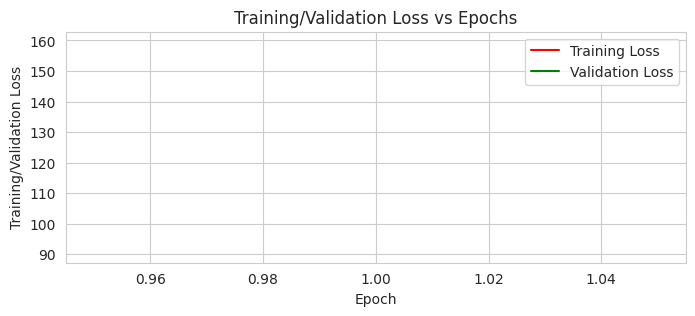

In [33]:
plt.figure(figsize = (8, 3))
plt.plot([epoch for epoch in range(1, EPOCHS+1)], train_loss_lst, color = 'red', label = "Training Loss")
plt.plot([epoch for epoch in range(1, EPOCHS+1)], validation_loss_lst, color = 'green', label = "Validation Loss")
plt.title("Training/Validation Loss vs Epochs")
plt.ylabel("Training/Validation Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [34]:
checkpoint_path = os.path.join('models','lipnet_checkpoint.weights.h5')
# ------------------------------------------------------------
test_model = LipNet(num_classes=char_to_num.vocabulary_size() + 1)

if os.path.exists(checkpoint_path):
    print(f"Loading weights from {checkpoint_path}...")
    try:
        _ = test_model(tf.zeros([1, FRAME_COUNT, FRAME_HEIGHT, FRAME_WIDTH, FRAME_CHANNELS]))
        test_model.load_weights(checkpoint_path)
        print("Weights loaded successfully.")
    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Ensure the model architecture matches the saved weights.")
else:
    print(f"Checkpoint file not found at {checkpoint_path}. Model is untrained.")


try:
    test_batch = next(iter(test_data.take(1)))
    video_batch, label_batch, vid_len_batch, label_len_batch = test_batch
    print(f"Loaded one batch for testing with {len(video_batch)} samples.")
except StopIteration:
    print("Could not get a batch from the test_data pipeline. Is it empty?")
    exit()
except Exception as e:
    print(f"Error getting data from test_data pipeline: {e}")
    exit()


print("Running predictions...")
yhat = test_model.predict(video_batch)
print(f"Prediction output shape: {yhat.shape}") # Should be (batch_size, 75, num_classes)

batch_actual_input_lengths = tf.cast(tf.fill([tf.shape(yhat)[0]], FRAME_COUNT), dtype='int32')

decoded_dense = tf.keras.backend.ctc_decode(yhat, batch_actual_input_lengths, greedy=True)[0][0]

N_EXAMPLES_TO_SHOW = min(2, len(video_batch))
print(f"\n--- Showing {N_EXAMPLES_TO_SHOW} Test Examples ---")

for i in range(N_EXAMPLES_TO_SHOW):
    print(f"\nExample {i+1}:")

    # Original Label
    original_indices = label_batch[i][:label_len_batch[i]] # Slice using actual label length
    # Ensure indices are int64 for num_to_char if needed (StringLookup is flexible)
    original_text = tf.strings.reduce_join(num_to_char(tf.cast(original_indices, dtype=tf.int64))).numpy().decode('utf-8')
    print(f'Original:     {original_text}')

    # Predicted Label
    raw_decoded_indices = decoded_dense[i].numpy()
    print(f'Raw Decoded:  {raw_decoded_indices}') # Uncomment for debugging

    # Filter out padding (-1) and blank index (CTC_BLANK_INDEX)
    filtered_indices = [x for x in raw_decoded_indices if x != -1 and x != CTC_BLANK_INDEX]
    print(f'Filtered Idx: {filtered_indices}') # Uncomment for debugging

    if filtered_indices:
         # Ensure indices are int64 for num_to_char if needed
         prediction_text = tf.strings.reduce_join(num_to_char(tf.constant(filtered_indices, dtype=tf.int64))).numpy().decode('utf-8')
    else:
         prediction_text = "[EMPTY PREDICTION]"
    print(f'Prediction:   {prediction_text}')
    print('-'*50)

print("--- Testing Finished ---")

Loading weights from models/lipnet_checkpoint.weights.h5...
Weights loaded successfully.
Loaded one batch for testing with 50 samples.
Running predictions...
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 775ms/step
Prediction output shape: (50, 75, 29)

--- Showing 2 Test Examples ---

Example 1:
Original:     bin white in m six please
Raw Decoded:  [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
Filtered Idx: [np.int64(0)]
Prediction:   
--------------------------------------------------

Example 2:
Original:     place red at j zero now
Raw Decoded:  [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1]
Filtered Idx: [np.int64(0)]
Prediction:   
-----